In [1]:
# import necessary libraries
import pandas as pd
import math
from sklearn.model_selection import train_test_split

# read data from training files
data = pd.read_csv("train.csv")

# set target and take away from training data
y = data.SalePrice
X = data.drop(["SalePrice"], axis=1)

In [2]:
# check for amount of missing values in dataset
# calculate total number of missing values in each column
# divide number of empty values by total length of column for each column in dataset with missing values
print("Column: (total missing, percentage of column length)")
[{x:(X[x].isna().sum(), math.ceil(X[x].isna().sum()*100/len(X.index)*100)/100)} 
for x in X.columns[X.isna().any()]]

Column: (total missing, percentage of column length)


[{'LotFrontage': (259, 17.74)},
 {'Alley': (1369, 93.77)},
 {'MasVnrType': (8, 0.55)},
 {'MasVnrArea': (8, 0.55)},
 {'BsmtQual': (37, 2.54)},
 {'BsmtCond': (37, 2.54)},
 {'BsmtExposure': (38, 2.61)},
 {'BsmtFinType1': (37, 2.54)},
 {'BsmtFinType2': (38, 2.61)},
 {'Electrical': (1, 0.07)},
 {'FireplaceQu': (690, 47.27)},
 {'GarageType': (81, 5.55)},
 {'GarageYrBlt': (81, 5.55)},
 {'GarageFinish': (81, 5.55)},
 {'GarageQual': (81, 5.55)},
 {'GarageCond': (81, 5.55)},
 {'PoolQC': (1453, 99.53)},
 {'Fence': (1179, 80.76)},
 {'MiscFeature': (1406, 96.31)}]

In [3]:
# get rid of unecessary columns
# drop anything with 90+ percent values missing as well as Id column
X.drop(columns=["Alley", "PoolArea", "PoolQC", "MiscFeature", "Id"], axis=1, inplace=True)

In [4]:
# categorical columns
# place low cardinatlity categorical columns
# check if uninique values is less than 10 and also a string
low_cat_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and X[cname].dtype == "object"]

# numerical columns
# check columns for all integer and float values
num_cols = [cname for cname in X.columns if X[cname].dtype in ["int64", "float64"]]

In [5]:
# set training and validation, split
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# impute numerical columns with median of column values
num_transformer = SimpleImputer(strategy="median")

# impute categorical columns with most frequent value and then one hot encode
cat_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), 
                                 ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# preprocess the columns
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_cols), 
                                              ("cat", cat_transformer, low_cat_cols)])

In [7]:
# create 2 models to test with
# random state to make solution easier to replicate
from sklearn.ensemble import RandomForestRegressor

#n_estimators increased to have more trees before taking average for predictions
# stop seeing meaningful improvements around 250
# min leaf size to capture noise in data
house_model = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=1)

from xgboost import XGBRegressor

#n_estimators increased to have more trees before taking average for predictions
# stop seeing meaningful improvements around 500
house_model_2 = XGBRegressor(n_estimators=500, learning_rate=0.1, random_state=1)

In [8]:
# calculate MAE for random
from sklearn.metrics import mean_absolute_error

# load preprocessed data and model into pipeline
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("house_model", house_model)])

# fit training data to pipeline
my_pipeline.fit(train_X, train_y)

# predict house scores based on model
predictions = my_pipeline.predict(val_X)

# calculate mean absolute error
score = mean_absolute_error(val_y, predictions)

print("MAE: ", score)

MAE:  16498.024520547944


In [9]:
# calculate MAE for XGBoost
from sklearn.metrics import mean_absolute_error

# load preprocessed data and model into pipeline
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("house_model_2", house_model_2)])

# fit training data to pipeline
my_pipeline.fit(train_X, train_y)

# predict house scores based on model
predictions = my_pipeline.predict(val_X)

# calculate mean absolute error
score = mean_absolute_error(val_y, predictions)

print("MAE: ", score)

MAE:  15232.421594071062


In [10]:
from sklearn.model_selection import cross_val_score

# cross validate scores to test model across all data
scores = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error")

print("MAE: ", scores)

MAE:  [16005.11531464 16493.71481699 17380.82285424 14613.80740315
 17304.69183433]


In [11]:
print("Average MAE: ", scores.mean())

# from these results, I can tell that the model is not very consistent at predicting house prices

Average MAE:  16359.630444670376


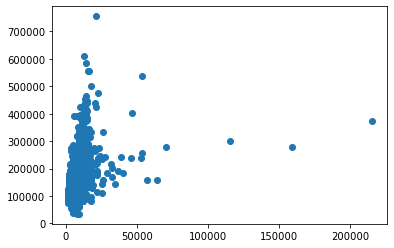

In [12]:
# scatter plot
import matplotlib.pyplot as plt

# plot Lot Area against house prices
plt.scatter(train_X.LotArea, train_y)
plt.show()

In [13]:
# if I'd had more time I would have changed a few things:

# firstly, I would have imputed values into columns in a more precise way
# currently, I removed columns with too many missing values and then used basic imputations for other columns
# for example, the PoolQC column which I removed could be imputed with "No Pool" instead of NA
# this could potentially be done with a label encoder

# secondly, I would have used scatter plots (as seen above) to try and find outliers to remove

# finally, I would have fine-tuned my XGBoost more
# right now, it is fairly basic, however still gives the best results compared to the Random Forest